<a href="https://colab.research.google.com/github/ipeirotis/autoencoders_census/blob/main/Autoencoder_YRBSS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from pandas.api.types import is_numeric_dtype

In [13]:
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.interpolate import interp1d
from numpy.random import uniform
from numpy.random import seed


In [14]:
from keras.layers import Input
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras import backend as K
from keras import Model



In [15]:
import tensorflow as tf
from tensorflow.random import set_seed
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Load Original Dataset

In [16]:
dataset_url = "https://github.com/ipeirotis/autoencoders_census/raw/main/sadc_2017only_national_full.csv"
original_df = pd.read_csv(dataset_url)


In [17]:
original_df.head()

,sitecode,sitename,sitetype,sitetypenum,year,survyear,weight,stratum,PSU,record,...,qnwenthungry,qnmusclestrength,qnsunscreenuse,qnindoortanning,qnsunburn,qnconcentrating,qncurrentasthma,qnwheresleep,qnspeakenglish,qntransgender
0,XX,United States (XX),National,3,2017,14,2.4095,111,171190,1509749,...,NaN,1.0,NaN,2.0,1.0,1.0,NaN,NaN,1.0,NaN
1,XX,United States (XX),National,3,2017,14,1.6614,212,170890,1509750,...,NaN,1.0,NaN,2.0,2.0,1.0,NaN,NaN,1.0,NaN
2,XX,United States (XX),National,3,2017,14,0.7049,212,170890,1509751,...,NaN,2.0,NaN,2.0,2.0,2.0,NaN,NaN,1.0,NaN
3,XX,United States (XX),National,3,2017,14,0.7966,212,170890,1509752,...,NaN,1.0,NaN,2.0,1.0,2.0,NaN,NaN,1.0,NaN
4,XX,United States (XX),National,3,2017,14,1.9776,202,160270,1509753,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
columns_to_drop = ['sitecode', 'sitename', 'sitetype', 'sitetypenum', 'year', 'survyear', 'record', 'stratum', 'PSU']
original_df = original_df.drop(columns = columns_to_drop, axis='columns')

In [19]:
original_df.shape

(14765, 305)

# Transforming the original data set

## Dropping uneccessary columns

In [20]:
# PANOS: I do not understand why keeping the first 100 columns.

# PANOS: Also, it would be a good idea to use more descriptive variable names than "df1"

df1 = original_df.iloc[:, :100]
df1.shape

(14765, 100)

In [21]:
# PANOS: I do not understand what are these columns that we keep

lst = [216, 232, 242, 245, 247, 249, 251, 252, 253, 256]
df1 = pd.concat([df1, original_df.iloc[:, lst]], axis=1)
df1.head()

,weight,age,sex,grade,race4,race7,stheight,stweight,bmi,bmipct,...,qpropertydamage,qgenderexp,qsugardrink,qfoodallergy,qmusclestrength,qindoortanning,qconcentrating,qcurrentasthma,qwheresleep,qnbikehelmet
0,2.4095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Not sure,3 days,0 times,Yes,NaN,NaN,NaN
1,1.6614,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Not sure,4 days,0 times,Yes,NaN,NaN,NaN
2,0.7049,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,No,1 day,0 times,No,NaN,NaN,NaN
3,0.7966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,No,3 days,0 times,No,NaN,NaN,NaN
4,1.9776,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
rename_columns = {
    "age": "age",
    "sex": "sex",
    "grade": "grade",
    "race4": "Hispanic_or_Latino",
    "race7": "race",
    "qnobese": "obese",
    "qnowt": "overweight",
    "q67": "sexual_identity",
    "q66": "sex/sexual_contacts",
    "sexid": "sexid",
    "sexid2": "sexid2",
    "sexpart": "sexpart",
    "sexpart2": "sexpart2",
    "q8": "seat_belt_use",
    "q9": "riding_with_a_drinking_driver",
    "q10": "drinking_and_driving",
    "q11": "texting_and_driving",
    "q12": "weapon_carrying",
    "q13": "weapon_carrying_at_school",
    "q14": "gun_carrying_past_12_mos",
    "q15": "safety_concerns_at_school",
    "q16": "threatened_at_school",
    "q17": "physical_fighting",
    "q18": "physical_fighting_at_school",
    "q19": "forced_sexual_intercourse",
    "q20": "sexual_violence",
    "q21": "sexual_dating_violence",
    "q22": "physical_dating_violence",
    "q23": "bullying_at_school",
    "q24": "electronic_bullying",
    "q25": "sad_or_hopeless",
    "q26": "considered_suicide",
    "q27": "made_a_suicide_plan",
    "q28": "attempted_suicide",
    "q29": "injurious_suicide_attempt",
    "q30": "ever_cigarette_use",
    "q31": "initation_of_cigarette_smoking",
    "q32": "current_cigarette_use",
    "q33": "smoking_amounts_per_day",
    "q34": "electronic_vapor_product_use",
    "q35": "current_electronic_vapor_product_use",
    "q36": "EVP_from_store",
    "q37": "current_smokeless_tobacco_use",
    "q38": "current_cigar_use",
    "q39": "all_tobacco_product_cessation",
    "q40": "ever_alcohol_use",
    "q41": "initiation_of_alcohol_use",
    "q42": "current_alcohol_use",
    "q43": "source_of_alcohol",
    "q44": "current_binge_drinking",
    "q45": "largest_number_of_drinks",
    "q46": "ever_marijuana_use",
    "q47": "initiation_of_marijuana_use",
    "q48": "current_marijuana_use",
    "q49": "ever_cocaine_use",
    "q50": "ever_inhalant_use",
    "q51": "ever_heroin_use",
    "q52": "ever_methamphetamine_use",
    "q53": "ever_ecstasy_use",
    "q54": "ever_synthetic_marijuana_use",
    "q55": "ever_steroid_use",
    "q56": "ever_prescription_pain_medicine_use",
    "q57": "illegal_injected_drug_use",
    "q58": "illegal_drugs_at_school",
    "q59": "ever_sexual_intercourse",
    "q60": "first_sex_intercourse",
    "q61": "multiple_sex_partners",
    "q62": "current_sexual_activity",
    "q63": "alcohol/drugs_at_sex",
    "q64": "condom_use",
    "q65": "birth_control_pill_use",
    "q68": "perception_of_weight",
    "q69": "weight_loss",
    "q70": "fruit_juice_drinking",
    "q71": "fruit_eating",
    "q72": "green _salad_eating",
    "q73": "potato_eating",
    "q74": "carrot_eating",
    "q75": "other_vegetable_eating",
    "q76": "soda_drinking",
    "q77": "milk_drinking",
    "q78": "breakfast_eating",
    "q79": "physical_activity",
    "q80": "television_watching",
    "q81": "computer_not_school_work_use",
    "q82": "PE_attendance",
    "q83": "sports_team_participation",
    "q84": "concussion_in_last_12_mos",
    "q85": "HIV_testing",
    "q86": "oral_health_care",
    "q87": "asthma",
    "q88": "sleep_on_school_night",
    "q89": "grades_in_school",
    "qdrivemarijuana": "drive_when_using_marijuana",
    "qhallucdrug": "ever_used_LSD",
    "qsportsdrink": "sports_drinks",
    "qwater": "plain_water",
    "qfoodallergy": "food_allergies",
    "qmusclestrength": "muscle_stregthening",
    "qindoortanning": "indoor_tanning",
    "qsunburn": "sunburn",
    "qconcentrating": "difficulty_concentrating",
    "qspeakenglish": "how_well_speak_English",
}

In [23]:
df1.rename(columns=rename_columns, inplace = True)

## Analysis of Missing Values

In [24]:
df1.isnull().sum()

weight                          0
age                            81
sex                           127
grade                         144
Hispanic_or_Latino            337
                            ...  
indoor_tanning               1751
difficulty_concentrating     4097
qcurrentasthma              14765
qwheresleep                 14765
qnbikehelmet                14765
Length: 110, dtype: int64

In [30]:
missing_percentages = df1.isnull().mean() * 100
columns_with_missing_gt_25 = missing_percentages[missing_percentages > 25].index

# Select the columns with missing values > 25%
# selected_columns = df1[columns_with_missing_gt_25]

# Print the selected columns
columns_with_missing_gt_25

Index(['attempted_suicide', 'injurious_suicide_attempt',
       'all_tobacco_product_cessation', 'source_of_alcohol',
       'largest_number_of_drinks', 'qpropertydamage', 'qgenderexp',
       'qsugardrink', 'food_allergies', 'muscle_stregthening',
       'difficulty_concentrating', 'qcurrentasthma', 'qwheresleep',
       'qnbikehelmet'],
      dtype='object')

In [26]:
# Iterate over each variable in the dataframe
# for column in selected_columns:
  # create a new column name by appending
  #missing_dummy_column = f'{column}_missing_dummy'
  #df1[missing_dummy_column] = df1[column].isnull().astype(int)

# Display the updated dataframe
# df1.head()

,weight,age,sex,grade,Hispanic_or_Latino,race,stheight,stweight,bmi,bmipct,...,largest_number_of_drinks_missing_dummy,qpropertydamage_missing_dummy,qgenderexp_missing_dummy,qsugardrink_missing_dummy,food_allergies_missing_dummy,muscle_stregthening_missing_dummy,difficulty_concentrating_missing_dummy,qcurrentasthma_missing_dummy,qwheresleep_missing_dummy,qnbikehelmet_missing_dummy
0,2.4095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,1,1,0,0,0,1,1,1
1,1.6614,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,1,1,0,0,0,1,1,1
2,0.7049,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,1,1,0,0,0,1,1,1
3,0.7966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,1,1,0,0,0,1,1,1
4,1.9776,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,1,1,0,1,1,1,1,1


In [38]:
numeric_vars = ["weight","stheight","stweight","bmi","bmipct","obese","overweight"]

In [40]:
categorical_vars = [c for c in df1.columns.values if c not in numeric_vars]

## Code that transforms a dataframe to vector format and vice versa




In [60]:
# PANOS: We should probably write a few tests for the code
# to ensure that it works


def transform_dataframe(df, variable_types):

    # Add dummies for missing values
    df_missing = pd.concat([df[c].isnull().astype(int) for c in df.columns], axis = 1)
    df_missing.columns = [f'{c}_missing' for c in df.columns]
    df = pd.concat([df, df_missing], axis='columns')

    # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
    one_hot_encoders = {}
    one_hot_columns = []

    # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
    min_max_scalers = {}

    for column, variable_type in variable_types.items():
        if variable_type == 'categorical':
            one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
            # one_hot_encoder.set_output(transform='pandas')
            df_encoded = pd.DataFrame(one_hot_encoder.fit_transform(df[[column]]))
            df_encoded.columns = [f"{column}_{cat}" for cat in one_hot_encoder.categories_[0]]
            one_hot_columns.append(df_encoded)
            df = pd.concat([df, df_encoded], axis=1)
            df = df.drop(column, axis=1)
            one_hot_encoders[column] = one_hot_encoder
        elif variable_type == 'numeric' and is_numeric_dtype(df[column]):
            min_max_scaler = MinMaxScaler()
            df[column] = min_max_scaler.fit_transform(df[[column]])
            min_max_scalers[column] = min_max_scaler
    

    
    # original_cat_cols = [c for c in variable_types if variable_types[c] == 'categorical' ]
    # df = df.drop(original_cat_cols, axis='columns')

    return df, one_hot_encoders, min_max_scalers



def proba_to_onehot(proba):
    '''
    Takes as input a vector of probabilities and converts it into 
    a max-likelihood one-hot vector
    '''
    onehot = np.zeros_like(proba)
    onehot[np.arange(len(proba)), np.argmax(proba, axis=1)] = 1
    return onehot

def reverse_transform_dataframe(df, variable_types, one_hot_encoders, min_max_scalers):
    for column, variable_type in variable_types.items():
        if variable_type == 'categorical':
            one_hot_encoder = one_hot_encoders[column]
            original_cols = [col for col in df.columns if col.startswith(f"{column}_")]
            df_proba = df[original_cols].values
            onehot = proba_to_onehot(df_proba)
            df_original = pd.DataFrame(one_hot_encoder.inverse_transform(onehot))
            df_original.columns = [column]
            df = pd.concat([df.drop(original_cols, axis=1), df_original], axis=1)
        elif variable_type == 'numeric' and is_numeric_dtype(df[column]):
            min_max_scaler = min_max_scalers[column]
            df[column] = min_max_scaler.inverse_transform(df[[column]])

    return df

In [61]:
variable_types = {}
for column in numeric_vars:
    variable_types[column] = 'numeric'

for column in categorical_vars:
    variable_types[column] = 'categorical'

transformed_df, one_hot_encoder, min_max_scaler = transform_dataframe(df1, variable_types)

# This code takes the vector representation and does the inverse transform
#original_df = reverse_transform_dataframe(transformed_df, variable_types, one_hot_encoder, min_max_scaler)

In [62]:
transformed_df.shape

(14765, 1522)

In [63]:
transformed_df.fillna(-1, inplace=True)

# Autoencoder training

## Architecture setup

In [64]:

# the dimensionality of a latent space in an autoencoder
latent_dimension = 1
batch_size = 20
# the number of nuerons in a hidden layer
hidden_nodes = 16

# The dimensionality of the dataframe is (nrows x dim).
# We keep the dim as the size of the input
input_dim = transformed_df.shape[1]

# create the input layer for the encoder
input_encoder = Input(shape=(input_dim,), name="Input_Encoder")
# apply batch normalization to the encoder input layer
batch_normalize1 = BatchNormalization()(input_encoder)
# create a hidden layer in the encoder
hidden_layer = Dense(hidden_nodes, activation="relu", name="Hidden_Encoding")(
    batch_normalize1
)
batch_normalize2 = BatchNormalization()(hidden_layer)
# create the output layer of the encoder
z = Dense(latent_dimension, name="Mean")(batch_normalize2)

In [65]:
encoder = Model(input_encoder, z, name="Encoder")

In [66]:
# create an input layer of the decoder
input_decoder = Input(shape=(latent_dimension,), name="Input_Decoder")
batch_normalize1 = BatchNormalization()(input_decoder)
# create a hidden layer
decoder_hidden_layer = Dense(hidden_nodes, activation="relu", name="Hidden_Decoding")(
    batch_normalize1
)
batch_normalize2 = BatchNormalization()(decoder_hidden_layer)
# create the output layer of the autoencoder
decoded = Dense(input_dim, activation="linear", name="Decoded")(batch_normalize2)

In [67]:
# specify the input and output layer of the decoder
decoder = Model(input_decoder, decoded, name="Decoder")

In [68]:
# create a complete autoencoder architecture
encoder_decoder = decoder(encoder(input_encoder))

ae = Model(input_encoder, encoder_decoder)
# a summary of the autoencoder model
ae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Encoder (InputLayer)  [(None, 1522)]            0         
                                                                 
 Encoder (Functional)        (None, 1)                 30537     
                                                                 
 Decoder (Functional)        (None, 1522)              25974     
                                                                 
Total params: 56,511
Trainable params: 53,401
Non-trainable params: 3,110
_________________________________________________________________


## Train the Model 

In [69]:


# set the seed for random number generation
set_seed(2021)
# compile the complete autoencoder model
ae.compile(loss="mean_squared_error", optimizer="adam")

# use checkpoint during model training
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
earlystopping = EarlyStopping(monitor='val_loss', patience=1, verbose=0)

# train the autoencoder model on the input data
history = ae.fit(
    transformed_df, transformed_df, shuffle=True, epochs=10, batch_size=20, validation_split=0.2, verbose=0
).history

## Examine Training Output Statistics

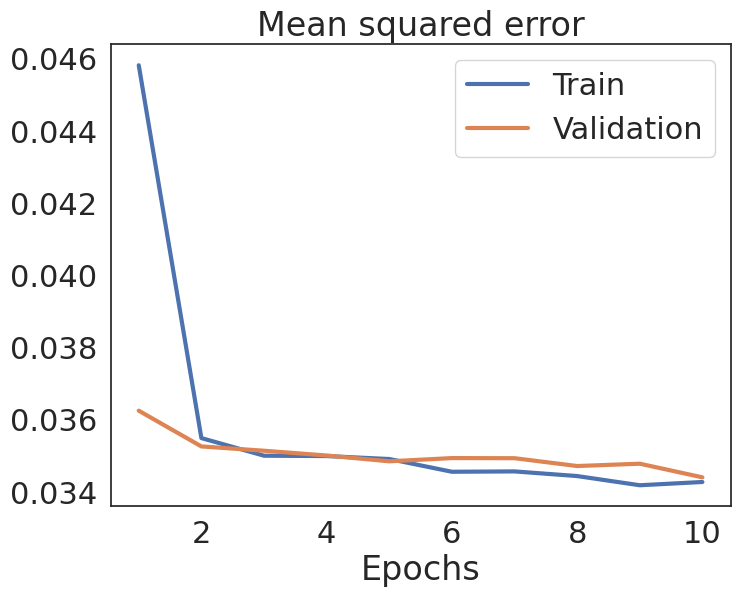

Training MSE = 0.18513809147251514
Validation MSE = 0.1854862214386088


In [71]:


sns.set(font_scale=2)
sns.set_style("white")


def model_analysis(history):
    # extract the training loss and validation loss values from the history object
    train_loss = history["loss"]
    val_loss = history["val_loss"]
    # x-axis values for the plot
    t = np.linspace(1, len(train_loss), len(train_loss))

    plt.figure(figsize=(8, 6))
    plt.title("Mean squared error")
    # plot the training loss and validation loss against the epoch values on the x-axis
    sns.lineplot(x=t, y=train_loss, label="Train", linewidth=3)
    sns.lineplot(x=t, y=val_loss, label="Validation", linewidth=3)
    plt.xlabel("Epochs")

    plt.legend()
    plt.savefig("FirstNet.png", dpi=400)
    plt.show()
    # the square root of the final training loss and validation loss values
    print(f"Training MSE = {np.sqrt(train_loss[-1])}")
    print(f"Validation MSE = {np.sqrt(val_loss[-1])}")


model_analysis(history)

462/462 [==============================] - 1s 2ms/step


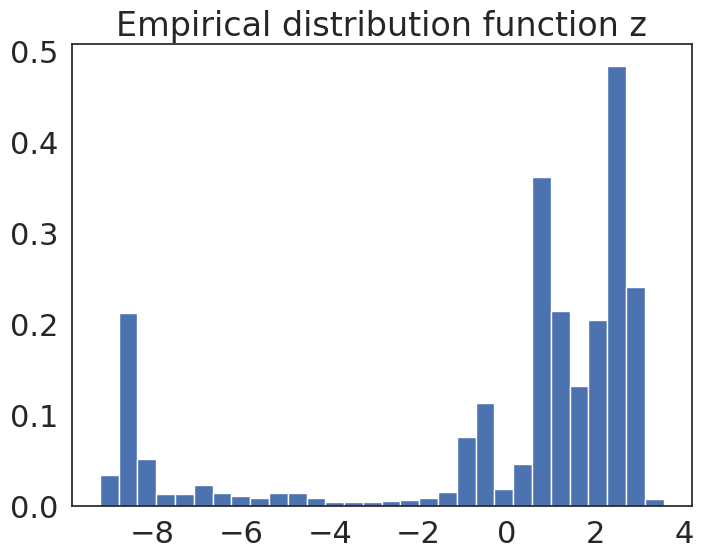

In [73]:
plt.figure(figsize=(8, 6))
plt.title("Empirical distribution function z")
plt.xticks((-8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14))
# use the encoder model to obtain the latent representation (z) of the data input
plt.hist(encoder.predict(transformed_df), bins=30, density=True)
plt.savefig("DistInternal.png", dpi=400)

In [74]:
ae.predict(transformed_df)[0,:]

462/462 [==============================] - 1s 2ms/step


array([0.2503833 , 0.41051498, 0.16757849, ..., 0.99833775, 1.0070289 ,
       1.0072447 ], dtype=float32)

462/462 [==============================] - 1s 3ms/step


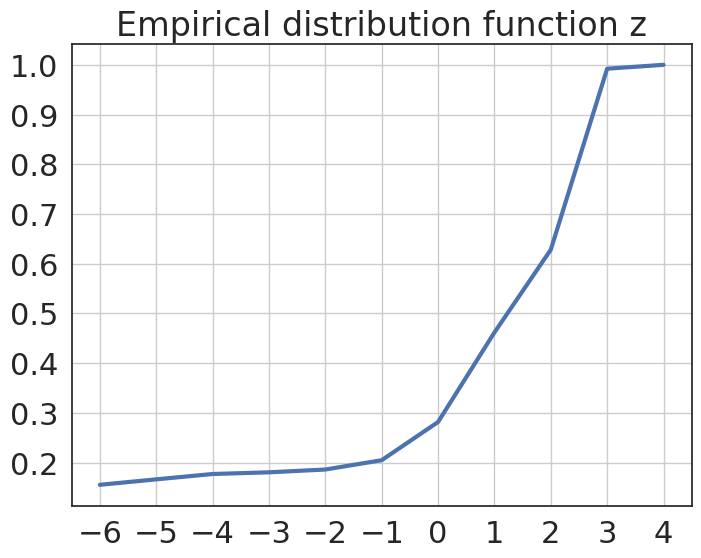

In [76]:
# plot the empirical distribution function for the values obtained from the encoder's predictions on the dataset



ecdf = ECDF(encoder.predict(transformed_df)[:, 0])
plt.figure(figsize=(8, 6))
plt.title("Empirical distribution function z")
x = (-6,-5, -4, -3, -2, -1, 0, 1, 2, 3, 4)
plt.yticks(np.linspace(0, 1, 11))
plt.xticks(x)
plt.grid()
plt.plot(x, ecdf(x), linewidth=3)
plt.savefig("EmpiricalDF.png", dpi=400)

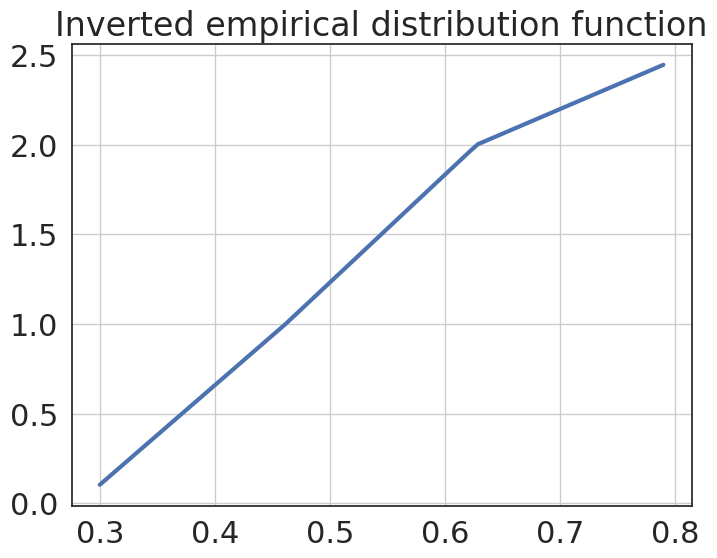

In [80]:
x = (-6,-5, -4, -3, -2, -1, 0, 1, 2, 3, 4)
# calculate the sample EDF values at the specified x-values
sample_edf_values_at_slope_changes = [ecdf(i) for i in x]
inverted_edf = interp1d(sample_edf_values_at_slope_changes, x)

# number of data points to generate
N = 10000
seed(2021)
plt.figure(figsize=(8, 6))
plt.title("Inverted empirical distribution function")
x = np.linspace(0.30, 0.79, 80)
plt.xticks(np.linspace(0, 1.0, 11))
plt.grid()
plt.plot(x, inverted_edf(x), linewidth=3)
plt.savefig("InvertedEmpiricalDF.png", dpi=400)

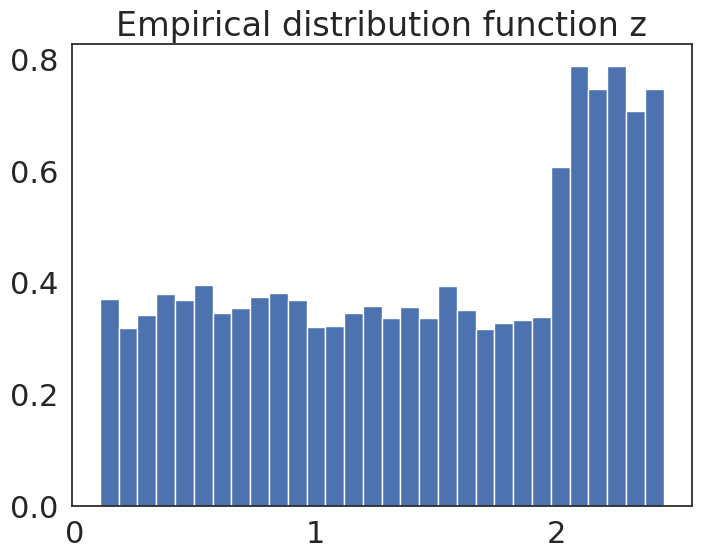

In [82]:
# number of data points to generate
N = 10000
seed(2021)
plt.figure(figsize=(8, 6))
plt.title("Empirical distribution function z")
plt.xticks((-5, -4, -3, -2, -1, 0, 1, 2, 3, 4))
# N random values from a uniform distribution are transformed to follow a specific distribution using the inverted EDF
plt.hist(inverted_edf(uniform(0.30, 0.79, N)), bins=30, density=True)
plt.savefig("DistGenerated.png", dpi=400)

462/462 [==============================] - 1s 2ms/step


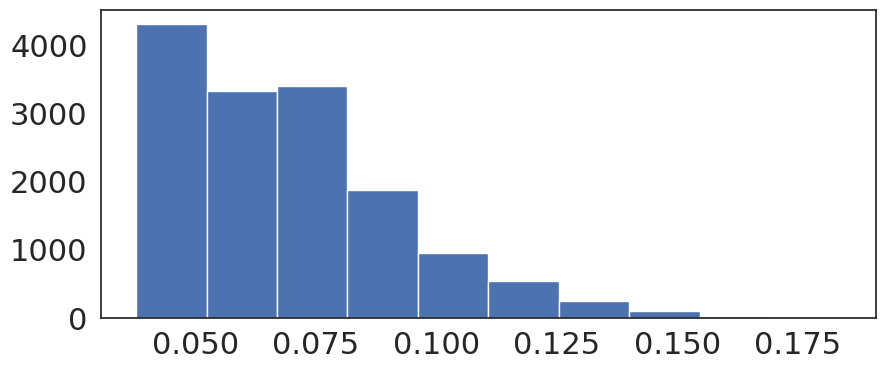

In [83]:
plt.figure(figsize=(10, 4))
# reconstruct the original data
normal_reconstructions = ae.predict(transformed_df)
# compute the Mean Absolute Error between the reconstructed data and the original data
normal_loss = tf.losses.mae(normal_reconstructions, transformed_df)
plt.hist(normal_loss, bins=10)
plt.show()

In [ ]:
threshold = np.mean(normal_loss) + 2*np.std(normal_loss)
print(threshold)

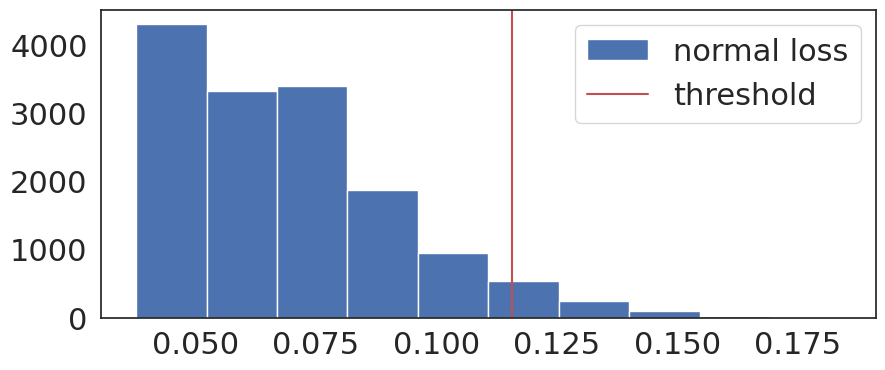

In [86]:
plt.figure(figsize=(10, 4))
plt.hist(normal_loss, bins=10, color='b', label="normal loss")
# add a vertical line to the plot at the position of the threshold value
plt.axvline(threshold, color='r', label="threshold")
plt.legend()
plt.show()

In [87]:
# Get the indices that would sort the mae array in descending order
sorted_indices = np.argsort(normal_loss)[::-1]

In [88]:
k = 100  # Number of samples to select
samples_with_high_error = transformed_df.iloc[sorted_indices[:k]]
samples_with_high_error.head()

,weight,stheight,stweight,bmi,bmipct,obese,overweight,weight_missing,age_missing,sex_missing,...,qsugardrink_missing_dummy_1,food_allergies_missing_dummy_0,food_allergies_missing_dummy_1,muscle_stregthening_missing_dummy_0,muscle_stregthening_missing_dummy_1,difficulty_concentrating_missing_dummy_0,difficulty_concentrating_missing_dummy_1,qcurrentasthma_missing_dummy_1,qwheresleep_missing_dummy_1,qnbikehelmet_missing_dummy_1
129,0.046169,-1.000000,-1.000000,-1.00000,-1.00000,-1.0,-1.0,0,1,0,...,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0
5028,0.046169,-1.000000,-1.000000,-1.00000,-1.00000,-1.0,-1.0,0,0,0,...,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0
1743,0.065919,0.605634,0.398231,0.12918,0.96569,0.0,1.0,0,0,0,...,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0
7167,0.286784,-1.000000,-1.000000,-1.00000,-1.00000,-1.0,-1.0,0,0,0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0
6313,0.101117,-1.000000,-1.000000,-1.00000,-1.00000,-1.0,-1.0,0,0,0,...,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0


In [89]:
# Find indices of tuples with reconstruction values larger than the threshold
anomaly_indices = np.where(normal_loss > threshold)[0]

# Select the corresponding tuples from the original data
anomaly_tuples = transformed_df.iloc[anomaly_indices]

# Print the anomaly tuples
anomaly_tuples.head()


,weight,stheight,stweight,bmi,bmipct,obese,overweight,weight_missing,age_missing,sex_missing,...,qsugardrink_missing_dummy_1,food_allergies_missing_dummy_0,food_allergies_missing_dummy_1,muscle_stregthening_missing_dummy_0,muscle_stregthening_missing_dummy_1,difficulty_concentrating_missing_dummy_0,difficulty_concentrating_missing_dummy_1,qcurrentasthma_missing_dummy_1,qwheresleep_missing_dummy_1,qnbikehelmet_missing_dummy_1
2,0.142144,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,1,1,...,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0
3,0.161873,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,1,1,...,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0
6,0.184979,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,1,1,...,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0
7,0.356232,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,1,1,...,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0
12,0.211872,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,1,1,...,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0


In [ ]:
anomaly_tuples.shape

(559, 654)

In [ ]:
# Generate the reconstructed output using the autoencoder
reconstructed_data = ae.predict(transformed_df)

# Convert the reconstructed data back to a dataframe
reconstructed_df = pd.DataFrame(reconstructed_data, columns=transformed_df.columns)

combined_df = pd.concat([transformed_df, reconstructed_df], axis=1)
combined_df.head()

462/462 [==============================] - 1s 2ms/step


,weight,stheight,stweight,bmi,bmipct,obese,overweight,age_12 years old or younger,age_13 years old,age_14 years old,...,qsugardrink_missing_dummy_1,food_allergies_missing_dummy_0,food_allergies_missing_dummy_1,muscle_stregthening_missing_dummy_0,muscle_stregthening_missing_dummy_1,difficulty_concentrating_missing_dummy_0,difficulty_concentrating_missing_dummy_1,qcurrentasthma_missing_dummy_1,qwheresleep_missing_dummy_1,qnbikehelmet_missing_dummy_1
0,0.508875,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,...,0.997379,0.932588,0.069094,0.921166,0.079978,0.930233,0.068759,0.998527,0.998399,0.999160
1,0.347927,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,...,0.989670,0.883507,0.092518,0.871231,0.108657,0.869888,0.106206,0.990015,0.994051,0.992062
2,0.142144,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,...,0.997988,0.819572,0.166138,0.818314,0.174790,0.797530,0.197725,0.996415,0.995633,0.995600
3,0.161873,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,...,0.998518,0.813569,0.172001,0.812350,0.180536,0.791693,0.203450,0.997122,0.996050,0.995917
4,0.415955,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,...,0.988603,0.876716,0.095759,0.864322,0.112625,0.861539,0.111388,0.988837,0.993449,0.991080
